In [0]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data

This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [0]:
mkdir 'data1'

In [0]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'

In [0]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [0]:
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    file_name = 'data1/' + file_name[41:]
    
    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Grouping all texts files
A dataframe is first created to keep individual files at their initial state, and the name of each file

In [0]:
import os
import pandas as pd

In [0]:
#list of the file names
files_list = os.listdir('data1')

In [0]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [0]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [0]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [11]:
# for verification purposes later, count the nr of characters for each content
sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
sources['file_len'].sum()

1779770

In [0]:
# variable containing the documents separately
corpus = sources['file_content']

In [0]:
# variable containing all documents together
all_texts = ''
for i in range(len(sources)):
  all_texts += sources['file_content'][i]

In [14]:
# check length
len(all_texts)

1779770

## 1.2 Removing stop words, punctuation, short words

In [0]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [0]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [0]:
# add new column in df with processed tokens
sources['tokens_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalnum() and len(w) > 3 )])

In [0]:
# these lines are useful if we want to provide alternate stop words lists (NLTK)
# show list of default NLTK Italian stopwords
# stopwords.words('italian')
# ital_stopwords = stopwords.words('italian')
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [0]:
# spacy list of Stop words (seems to be more complete than NLTK)
import spacy
from spacy.lang.it.stop_words import STOP_WORDS

In [0]:
spacy_it_sw = STOP_WORDS

In [0]:
# add column with tokenized documents without sw
sources['tokens_prep_nostop'] = sources['tokens_prep'].apply(lambda x: [w for w in x if not w in spacy_it_sw])

## 1.3 Stem

In [0]:
from nltk.stem.snowball import SnowballStemmer

In [0]:
#initialize with needed language
stemmer = SnowballStemmer("italian")

In [0]:
# add column with stemmed tokens
sources['tokens_stemmed'] = sources['tokens_prep_nostop'].apply(lambda x: [stemmer.stem(w) for w in x])

## 1.4 Lemmatize

In [0]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [0]:
%%capture
!python -m spacy download it_core_news_sm

In [0]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [0]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [0]:
# add column with lemmatized tokens
sources['tokens_lemmatized'] = sources['tokens_prep_nostop'].apply(lambda x: lemmatize(x))

In [0]:
# variable with lemmatized tokens
lemmatized_corpus = sources['tokens_lemmatized']

# 2. Topics with LDA

In [0]:
#Gensim installation
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA


### 2.1.1 Bag of words

In [0]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

In [0]:
# create a human friendly view of term frequency list
# I leave the line below for testing purposes
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1000]]

In [0]:
# list of words and frequency
words = []
frequency = []

for cp in corpus:
  word_id = list(cp[0])[0]
  words.append(id2word[list(cp[0])[0]])
  frequency.append(list(cp[0])[1])

In [0]:
words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [30]:
# sort descending
words_frequency.sort_values(by=['frequency'], ascending=False)[:10]
# frequency is on a per document basis

,word,frequency
95,aggiungere,6
4,anarchico,4
30,amico,4
99,aggiungere,3
15,agosto,3
73,anarchico,3
10,alia,3
44,alia,3
47,alia,3
28,abbassare,2


### 2.1.2 Visualize Gensim LDA results

In [0]:
# Plotting tools
%%capture
! pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

In [0]:
# insert the model and number of topics you want to visualise
# here LDA Gensim with 7 topics
%%capture
selected_model = models.LdaModel(corpus, id2word=id2word, num_topics=7)

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(selected_model, corpus, id2word)

In [34]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005770  0.000621       1        1  34.621796
6      0.001919  0.005652       2        1  18.748514
2      0.002574 -0.002055       3        1  15.816063
3      0.001043 -0.000836       4        1  12.616102
4      0.000419 -0.002100       5        1   8.250906
1      0.000636 -0.000875       6        1   5.513863
5     -0.000821 -0.000408       7        1   4.432759, topic_info=             Term        Freq       Total Category  logprob  loglift
270      italiano  995.000000  995.000000  Default  30.0000  30.0000
269        italia  494.000000  494.000000  Default  29.0000  29.0000
855     dispaccio  450.000000  450.000000  Default  28.0000  28.0000
1409  telegrafico  384.000000  384.000000  Default  27.0000  27.0000
219      giornale  303.000000  303.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1253   quotidiano    7.507830  199.136215   Topic7  -6.6281  -0.1619
599        venire    9.451167  349.611755   Topic7  -6.3979  -0.4945
1501         york    7.243026  197.614777   Topic7  -6.6640  -0.1901
1058       maggio    6.620214  149.017426   Topic7  -6.7539   0.0022
647         altro    6.585414  150.345840   Topic7  -6.7591  -0.0119

[639 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
27679      1  0.660792   1400
15761      1  0.362083   1883
15761      2  0.181042   1883
15761      3  0.181042   1883
15761      4  0.181042   1883
...      ...       ...    ...
625        3  0.124597  zione
625        4  0.116291  zione
625        5  0.066452  zione
625        6  0.049839  zione
625        7  0.041532  zione

[1709 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 3, 4, 5, 2, 6])

### 2.1.3. TFIDF

In [0]:
# optional
# TFIDF for better performance
# https://en.wikipedia.org/wiki/Tf–idf / 
# https://rare-technologies.com/pivoted-document-length-normalisation/

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## 2.2 LDA with TFIDF

In [0]:
# set the number of topics here
numtopics = 7

In [0]:
%%capture
ldagensim_tfidf = models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=numtopics)


In [39]:
ldagensim_tfidf.print_topics()

[(0,
  '0.000*"available" + 0.000*"text" + 0.000*"cardinale" + 0.000*"xiii" + 0.000*"papa" + 0.000*"leone" + 0.000*"oreglia" + 0.000*"papato" + 0.000*"produzione" + 0.000*"riduzione"'),
 (1,
  '0.000*"diamond" + 0.000*"black" + 0.000*"cardinale" + 0.000*"pescatore" + 0.000*"salmone" + 0.000*"negro" + 0.000*"giugno" + 0.000*"dragare" + 0.000*"regina" + 0.000*"crisi"'),
 (2,
  '0.000*"cardinale" + 0.000*"salma" + 0.000*"mascagni" + 0.000*"pontefice" + 0.000*"miniera" + 0.000*"xiii" + 0.000*"ebreo" + 0.000*"uovo" + 0.000*"conclave" + 0.000*"leone"'),
 (3,
  '0.000*"cardinale" + 0.000*"bovio" + 0.000*"marconi" + 0.000*"aprile" + 0.000*"papa" + 0.000*"guglielmo" + 0.000*"maggio" + 0.000*"pontefice" + 0.000*"mascagni" + 0.000*"sociale"'),
 (4,
  '0.000*"cardinale" + 0.000*"marconi" + 0.000*"garibaldi" + 0.000*"schedare" + 0.000*"studente" + 0.000*"papa" + 0.000*"immigrazione" + 0.000*"serbia" + 0.000*"immigrare" + 0.000*"edoardo"'),
 (5,
  '0.000*"cardinale" + 0.000*"mayor" + 0.000*"mafia" +

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [0]:
from gensim.models.coherencemodel import CoherenceModel

In [41]:
coherence_model_ldagensim_tfidf = CoherenceModel(model=ldagensim_tfidf, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim_tfidf = coherence_model_ldagensim_tfidf.get_coherence()
print('\nCoherence Score LDA Gensim TFIDF: ', coherence_ldagensim_tfidf)


Coherence Score LDA Gensim TFIDF:  0.46494190233885185


## 2.4 Coherence and number of topics

In [0]:
#can take a long time to run
%%capture
topics_nr = []
coherence_values_tfidf = []
for num_topics in range(2, 20):
  model = models.LdaModel(corpus_tfidf, id2word=id2word, num_topics=num_topics)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_tfidf.append(coherence_value)
  topics_nr.append(str(num_topics))

In [46]:
  for i in range(len(topics_nr)):
    coherence = round(coherence_values_tfidf[i],4)
    print("Num Topics =", topics_nr[i], " has Coherence Value of", coherence)

Num Topics = 2  has Coherence Value of 0.3066
Num Topics = 3  has Coherence Value of 0.3657
Num Topics = 4  has Coherence Value of 0.3514
Num Topics = 5  has Coherence Value of 0.3862
Num Topics = 6  has Coherence Value of 0.4575
Num Topics = 7  has Coherence Value of 0.4533
Num Topics = 8  has Coherence Value of 0.5136
Num Topics = 9  has Coherence Value of 0.4689
Num Topics = 10  has Coherence Value of 0.5295
Num Topics = 11  has Coherence Value of 0.5147
Num Topics = 12  has Coherence Value of 0.5173
Num Topics = 13  has Coherence Value of 0.5212
Num Topics = 14  has Coherence Value of 0.5525
Num Topics = 15  has Coherence Value of 0.5306
Num Topics = 16  has Coherence Value of 0.5449
Num Topics = 17  has Coherence Value of 0.5534
Num Topics = 18  has Coherence Value of 0.5322
Num Topics = 19  has Coherence Value of 0.5123


In [0]:
# Visualize coherence scores
import matplotlib.pyplot as plt

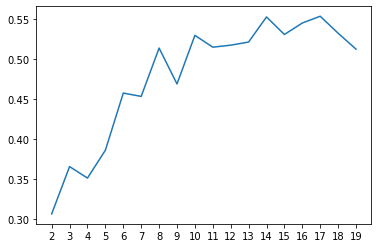

In [48]:
plt.plot(topics_nr, coherence_values_tfidf)

# Topic distribution

## 1. Distribution per topic and per document



In [0]:
%%capture
ldamodel = models.LdaModel(corpus_tfidf, num_topics=7, id2word = id2word, minimum_probability=0)

In [0]:
distribution = pd.DataFrame(index=[i for i in range(len(corpus_tfidf))],columns=[f'topic{i}' for i in range(numtopics)])

In [0]:
for i in range(len(corpus_tfidf)):
  row = [list(j)[1] for j in ldamodel[corpus_tfidf[i]]] 
  distribution.loc[i] = row

In [0]:
# add file name
distribution.insert(0, 'document_path', sources['file_name'])

In [53]:
distribution

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6
0,2012271201_1903-08-01_ed-1_seq-1_ocr.txt,0.962305,0.00628172,0.00627854,0.00628502,0.0062878,0.00627843,0.00628388
1,sn85066408_1903-06-22_ed-1_seq-1_ocr.txt,0.00535479,0.00535112,0.00534753,0.967882,0.00536317,0.00534615,0.00535483
2,sn85066408_1903-06-19_ed-1_seq-1_ocr.txt,0.968018,0.0053294,0.00532615,0.00533768,0.00533189,0.00532448,0.0053326
3,sn85066408_1903-05-30_ed-1_seq-1_ocr.txt,0.00523797,0.00523643,0.0052405,0.00523833,0.00523947,0.0052373,0.96857
4,2012271201_1903-07-18_ed-1_seq-1_ocr.txt,0.00637453,0.00638436,0.00636743,0.00637573,0.961758,0.00636645,0.00637381
...,...,...,...,...,...,...,...,...
95,sn85066408_1903-07-03_ed-1_seq-1_ocr.txt,0.00480256,0.00481051,0.00479725,0.00480528,0.00480181,0.00479555,0.971187
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.00524682,0.509873,0.00524044,0.00524665,0.00524974,0.00523926,0.463905
97,sn85066408_1903-05-25_ed-1_seq-1_ocr.txt,0.0050052,0.00500397,0.00500508,0.969972,0.0050065,0.00499991,0.00500696
98,sn85066408_1903-07-09_ed-1_seq-1_ocr.txt,0.00496531,0.00496375,0.00496585,0.00496589,0.00496574,0.00496034,0.970213


## 2. Distribution per topic for the whole corpus

In [54]:
topics = []
topic_weights = []
for i in range(len(distribution.columns)-1):
  topic_weight = round(sum(distribution.iloc[:,i+1]),2)
  topic_weights.append(topic_weight)
  print( f'topic {i}: {topic_weight}%' )
  topic = ldagensim_tfidf.print_topics()[i][1]
  topics.append(i)
  print( f'terms: {topic} ')

topic 0: 17.71%
terms: 0.000*"available" + 0.000*"text" + 0.000*"cardinale" + 0.000*"xiii" + 0.000*"papa" + 0.000*"leone" + 0.000*"oreglia" + 0.000*"papato" + 0.000*"produzione" + 0.000*"riduzione" 
topic 1: 11.8%
terms: 0.000*"diamond" + 0.000*"black" + 0.000*"cardinale" + 0.000*"pescatore" + 0.000*"salmone" + 0.000*"negro" + 0.000*"giugno" + 0.000*"dragare" + 0.000*"regina" + 0.000*"crisi" 
topic 2: 5.16%
terms: 0.000*"cardinale" + 0.000*"salma" + 0.000*"mascagni" + 0.000*"pontefice" + 0.000*"miniera" + 0.000*"xiii" + 0.000*"ebreo" + 0.000*"uovo" + 0.000*"conclave" + 0.000*"leone" 
topic 3: 17.39%
terms: 0.000*"cardinale" + 0.000*"bovio" + 0.000*"marconi" + 0.000*"aprile" + 0.000*"papa" + 0.000*"guglielmo" + 0.000*"maggio" + 0.000*"pontefice" + 0.000*"mascagni" + 0.000*"sociale" 
topic 4: 21.0%
terms: 0.000*"cardinale" + 0.000*"marconi" + 0.000*"garibaldi" + 0.000*"schedare" + 0.000*"studente" + 0.000*"papa" + 0.000*"immigrazione" + 0.000*"serbia" + 0.000*"immigrare" + 0.000*"edoardo

In [0]:
# dataframe with values to sort them by order of importance
distribution_df = pd.DataFrame(topic_weights, columns=['weight'])

In [0]:
distribution_df['topics'] = topics
distribution_df['topics'] = distribution_df['topics'].apply(lambda x: f'topic {x}')
distribution_df = distribution_df.sort_values(by=['weight'])

Text(0.5, 0, 'Weight (%)')

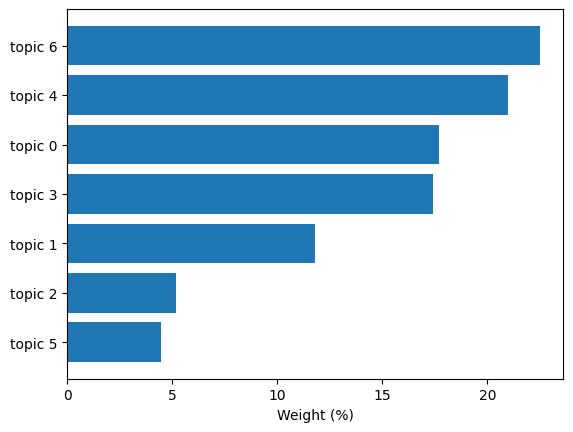

In [57]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(distribution_df['topics'], distribution_df['weight'], align='center')
ax.set_xlabel('Weight (%)')